### Dimensionality Reduction Comparison
#### Low-Dimensional Datasets / Feature Selection
##### 26Nov18
If I don't have to prime t-SNE and UMAP with PCA, I can compare these methods directly by their correlation with the 'raw' data.

In [6]:
import fcc_utils # this should have most of what we need for basics - PCA, tSNE, reading .hdf5 files, DCA, etc.
from fcc_DRs import *

Using TensorFlow backend.


In [2]:
import zipfile
# let's also get the basics
import numpy as np
import scipy as sc
import pandas as pd

# and some extra scikit packages
import skbio
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# density peak clustering
from pydpc import Cluster

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

---
Read in dataset from **p-Creode** example data.  
This should already be feature-selected and normalized. With ~170 features (genes), I can compare each reduction directly to the raw data, and I don't need to prime t-SNE or UMAP with PCA.  
Let's look at correlations between PCA, t-SNE, UMAP, and the raw, feature-selected dataset.

In [3]:
myeloid = pd.read_csv('inputs/Myeloid_with_IDs.csv')
# extract data from pandas dataframe as np.ndarray
myeloid_vals = np.ascontiguousarray(myeloid.values, dtype='double')

In [4]:
myeloid_vals.shape

(4423, 171)

In [10]:
# this data is already normalized and transformed into appropriate space
# perform PCA with TWO components to compare to tSNE/UMAP
myeloid_PCA = fcc_PCA(myeloid_vals, n_components=2)

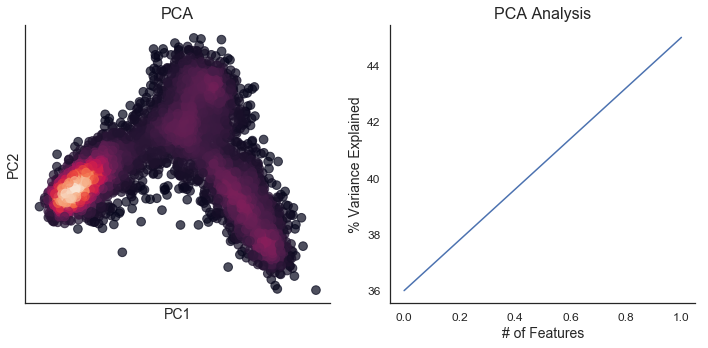

In [11]:
myeloid_PCA.plot()

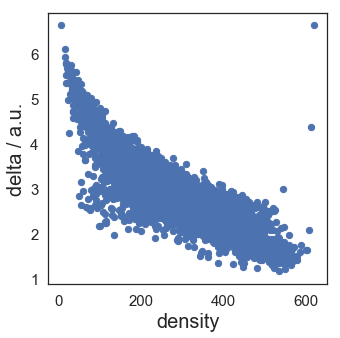

In [6]:
myeloid_pca_clu = Cluster(myeloid_PCA)

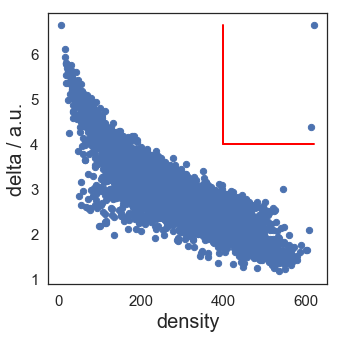

In [7]:
myeloid_pca_clu.assign(400,4)

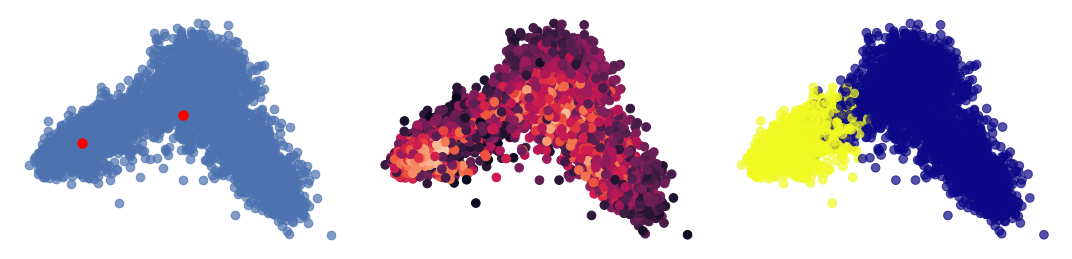

In [8]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_PCA[:, 0], myeloid_PCA[:, 1], s=75, alpha=0.7)
ax[0].scatter(myeloid_PCA[myeloid_pca_clu.clusters, 0], myeloid_PCA[myeloid_pca_clu.clusters, 1], s=90, c="red")
ax[1].scatter(myeloid_PCA[:, 0], myeloid_PCA[:, 1], s=75, c=myeloid_pca_clu.density)
ax[2].scatter(myeloid_PCA[:, 0], myeloid_PCA[:, 1], s=75, c=myeloid_pca_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [9]:
# calculate silhouette score for clustered results
silhouette_score(myeloid_PCA, myeloid_pca_clu.membership)

0.275603571377474

---
Perform t-SNE on these data, not PCA-primed

In [12]:
%time myeloid_tSNE = fcc_tSNE(myeloid_vals, perplexity=30)

CPU times: user 41.1 s, sys: 1.51 s, total: 42.6 s
Wall time: 43.4 s


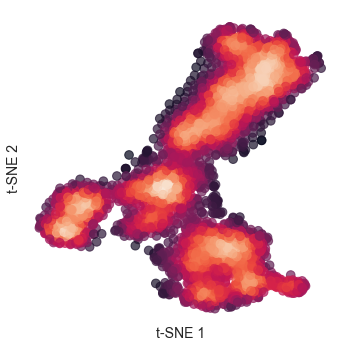

In [13]:
myeloid_tSNE.plot()

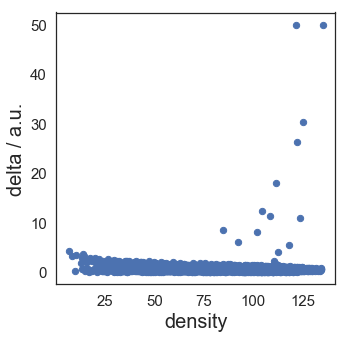

In [11]:
myeloid_tsne_clu = Cluster(myeloid_tSNE.astype('double')) # perform density peak clustering on tSNE for myeloid dataset

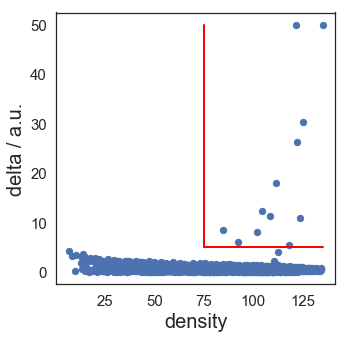

In [12]:
myeloid_tsne_clu.assign(75,5) # assign cluster centers; looks like there's only one for this dataset

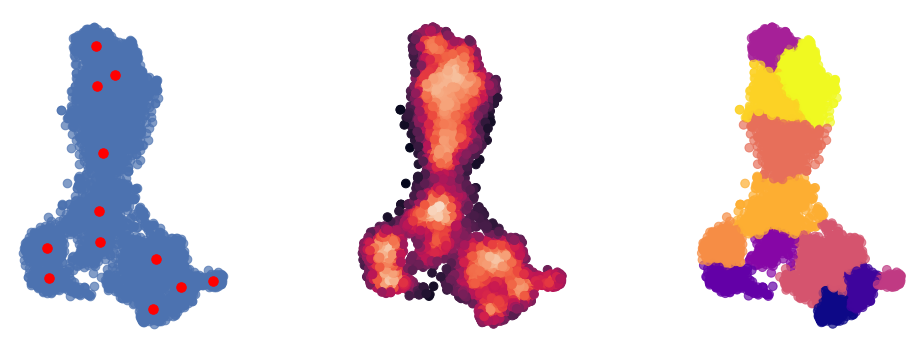

In [13]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(myeloid_tSNE[myeloid_tsne_clu.clusters, 0], myeloid_tSNE[myeloid_tsne_clu.clusters, 1], s=90, c="red")
ax[1].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, c=myeloid_tsne_clu.density)
ax[2].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, c=myeloid_tsne_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [14]:
# calculate silhouette score for clustered results
silhouette_score(myeloid_tSNE, myeloid_tsne_clu.membership)

0.361873

---
Perform UMAP on these data

In [14]:
%time myeloid_UMAP = fcc_UMAP(myeloid_vals, perplexity=30)

CPU times: user 21.5 s, sys: 589 ms, total: 22.1 s
Wall time: 22.4 s


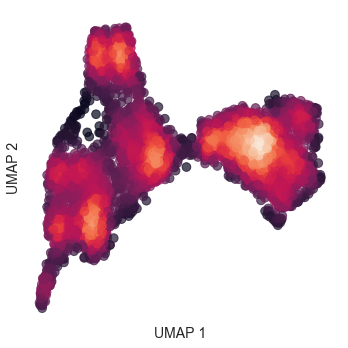

In [15]:
myeloid_UMAP.plot()

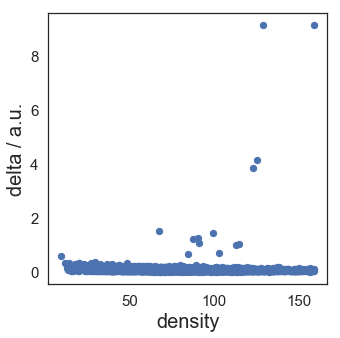

In [16]:
myeloid_umap_clu = Cluster(myeloid_UMAP.astype('double'))

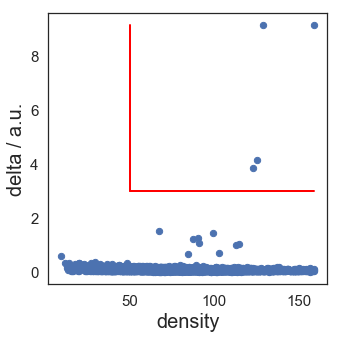

In [17]:
myeloid_umap_clu.assign(50,3)

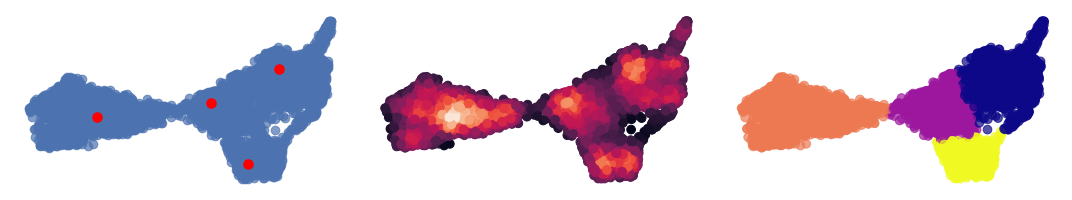

In [18]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_UMAP[:, 0], myeloid_UMAP[:, 1], s=75, alpha=0.7)
ax[0].scatter(myeloid_UMAP[myeloid_umap_clu.clusters, 0], myeloid_UMAP[myeloid_umap_clu.clusters, 1], s=90, c="red")
ax[1].scatter(myeloid_UMAP[:, 0], myeloid_UMAP[:, 1], s=75, c=myeloid_umap_clu.density)
ax[2].scatter(myeloid_UMAP[:, 0], myeloid_UMAP[:, 1], s=75, c=myeloid_umap_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [19]:
# calculate silhouette score for clustered results
silhouette_score(myeloid_UMAP, myeloid_umap_clu.membership)

0.5583159

---
Now compare UMAP to t-SNE using cell-cell distance correlation and distribution metrics.  
I updated this comparison in a few ways:  
* Euclidean distances are __normalized__ within each dataset by dividing all distances by the maximum value, yielding fractions between [0, 1]
* EMD and KLD are calculated using the cumulative probability distributions of the normalized distances

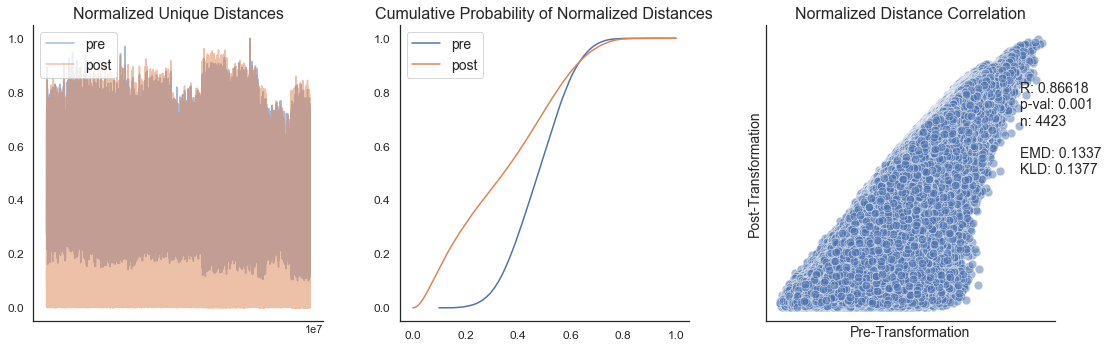

CPU times: user 13min 22s, sys: 3min 52s, total: 17min 14s
Wall time: 17min 32s


In [17]:
%time mantel_pca, EMD_pca, KLD_pca = fcc_utils.compare_euclid(pre=myeloid_vals, post=myeloid_PCA.results)

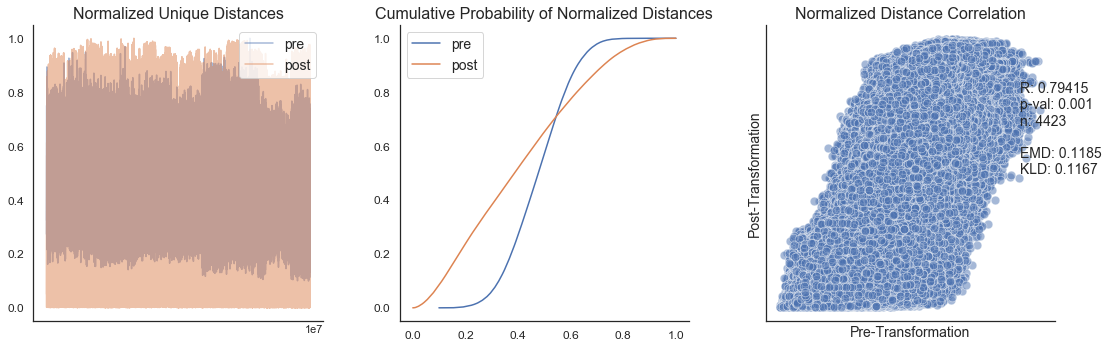

CPU times: user 13min 15s, sys: 3min 33s, total: 16min 48s
Wall time: 17min 6s


In [18]:
%time mantel_tsne, EMD_tsne, KLD_tsne = fcc_utils.compare_euclid(pre=myeloid_vals, post=myeloid_tSNE.results)

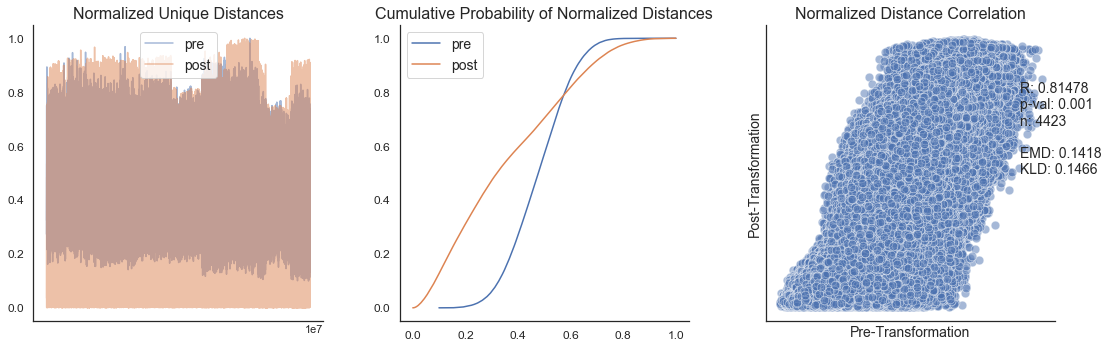

CPU times: user 13min 55s, sys: 3min 41s, total: 17min 36s
Wall time: 17min 45s


In [19]:
%time mantel_umap, EMD_umap, KLD_umap = fcc_utils.compare_euclid(pre=myeloid_vals, post=myeloid_UMAP.results)

---
---
##### NVR Testing
Try out feature selection with NVR.  
First take a full dataset and process it as I have been:

In [19]:
# read in continuous dataset
zf = zipfile.ZipFile('inputs/323-AS-3_S3_counts_mouse_filter.csv.zip') 
file = zf.open('323-AS-3_S3_counts_mouse_filter.csv')

In [21]:
file.name

'323-AS-3_S3_counts_mouse_filter.csv'

In [ ]:
dat = pd.read_csv(file)

In [5]:
dat.columns

Index(['Unnamed: 0', 'X0610006L08Rik', 'X0610007P14Rik', 'X0610009B22Rik',
       'X0610009E02Rik', 'X0610009L18Rik', 'X0610009O20Rik', 'X0610010F05Rik',
       'X0610010K14Rik', 'X0610011F06Rik',
       ...
       'snoU18', 'snoU2.30', 'snoU2_19', 'snoU83B', 'snoZ196', 'snoZ278',
       'snoZ40', 'snoZ6', 'snosnR66', 'uc_338'],
      dtype='object', length=38255)

In [6]:
# get rid of empty column with cell IDs
dat.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# convert to numpy array for NVR feature selection
d = np.asarray(dat.as_matrix())

In [8]:
d.shape

(2580, 38254)

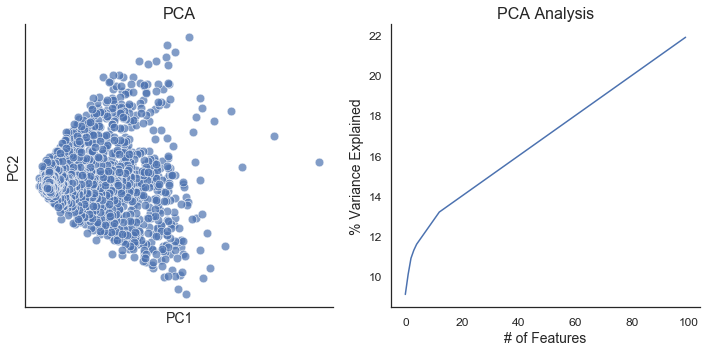

In [9]:
norm = fcc_utils.arcsinh_norm(d)
PCA = fcc_utils.fcc_PCA(norm, n_comp=100)

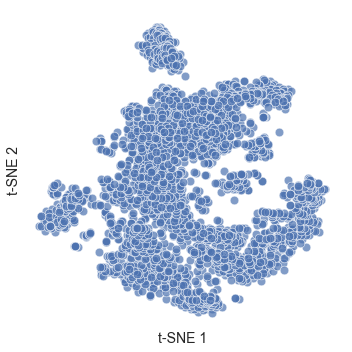

In [10]:
tSNE = fcc_utils.fcc_tSNE(PCA, p=50) # perplexity 50

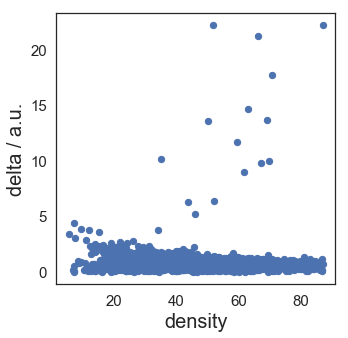

In [11]:
tsne_clu = Cluster(tSNE.astype('double'))

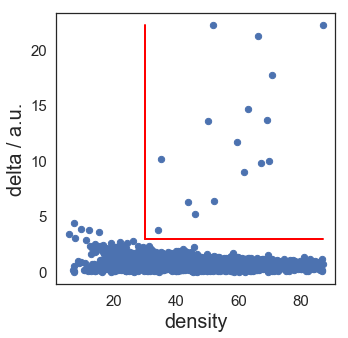

In [12]:
tsne_clu.assign(30,3)

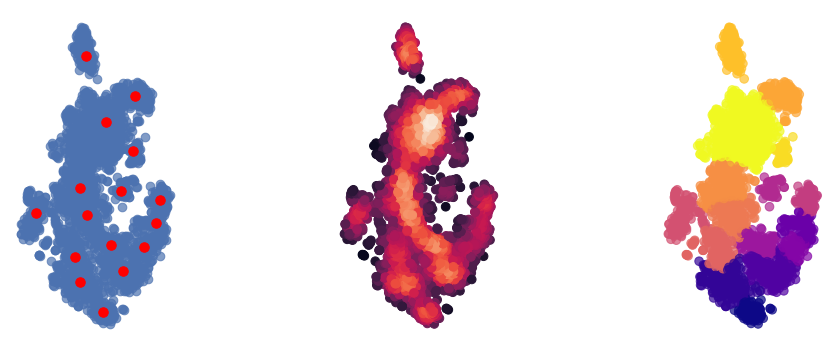

In [13]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(tSNE[:, 0], tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(tSNE[tsne_clu.clusters, 0], tSNE[tsne_clu.clusters, 1], s=90, c="red")
ax[1].scatter(tSNE[:, 0], tSNE[:, 1], s=75, c=tsne_clu.density)
ax[2].scatter(tSNE[:, 0], tSNE[:, 1], s=75, c=tsne_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [14]:
# calculate silhouette score for clustered results
silhouette_score(tSNE, tsne_clu.membership)

0.4025026

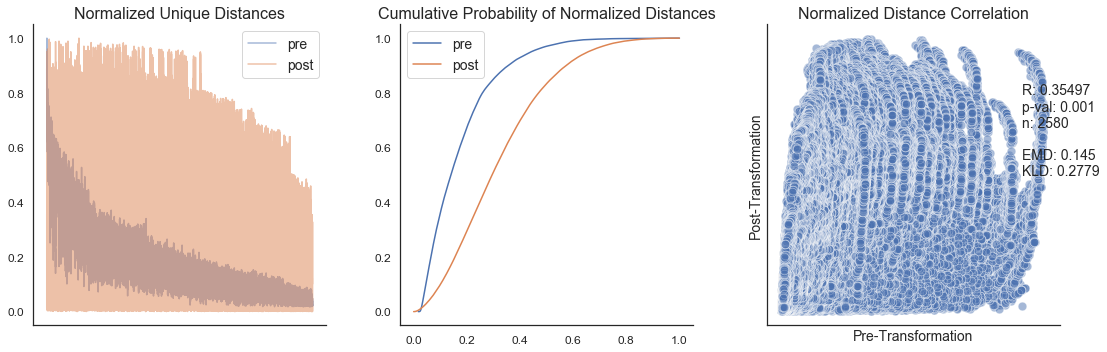

CPU times: user 3min 32s, sys: 22.7 s, total: 3min 55s
Wall time: 3min 58s


((0.35497319946394906, 0.001, 2580), 0.14495212436681593, 0.27790414450921896)

In [17]:
%time fcc_utils.compare_euclid(pre=PCA, post=tSNE)

Perform DCA on raw data and compare to PCA

In [15]:
%time dca = fcc_utils.fcc_DCA(d)

DCA: Successfully preprocessed 30297 genes and 2580 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 15min 31s, sys: 3min 27s, total: 18min 58s
Wall time: 8min 25s


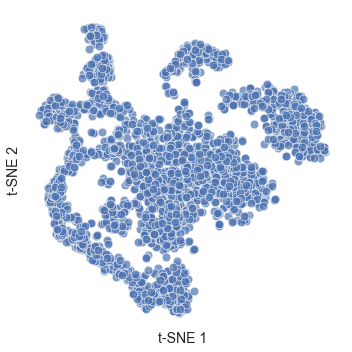

CPU times: user 5min 47s, sys: 2.61 s, total: 5min 49s
Wall time: 8min 25s


In [16]:
%time dca_tSNE = fcc_utils.fcc_tSNE(dca, p=50)

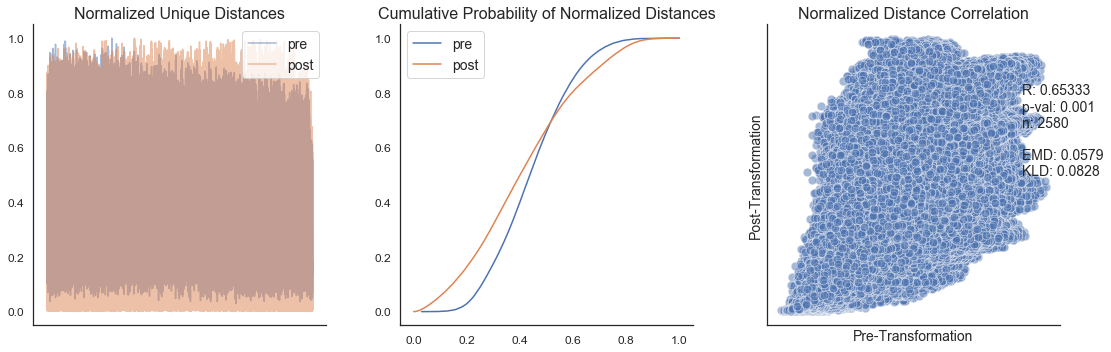

CPU times: user 13min 47s, sys: 9min 10s, total: 22min 58s
Wall time: 23min 14s


((0.6533337084573064, 0.001, 2580), 0.05794282603699513, 0.08277386293017062)

In [18]:
%time fcc_utils.compare_euclid(pre=dca, post=dca_tSNE)

---
##### NVR Feature Selection

In [24]:
import nvr

In [30]:
hqGenes=nvr.parseNoise(d)
dHq=nvr.mkIndexedArr(d,hqGenes)
dHq.shape

(2580, 15638)

In [31]:
dataHq=nvr.pwArcsinh(dHq,5000)

Completion:


In [32]:
d_selected_genes=nvr.select_genes(dataHq)

Start min_conn_k
3 connections needed
Finished min_conn_k 
Start traj_dist
Finished traj_dist
Start adaptive_knn_graph
Finished adaptive_knn_graph
Start global variance calculation
Finished global variance calculation
Start neighborhood variance calculation
Completion:
Finished neighborhood variance calculation
Start global to neighborhood variance ratio calculation
Finished global to neighborhood variance ratio calculation
Finished selection_val
Finished gene selection in 1967.9319758415222 seconds
done


In [33]:
d_selected_genes.shape

(206,)

In [37]:
nvr_data = dataHq[:,d_selected_genes]
nvr_data.shape

(2580, 206)

Now, perform DR techniques on selected, normalized genes and compare to the above matrix.

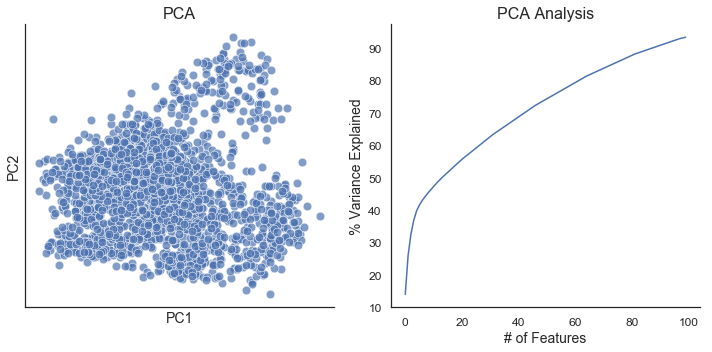

CPU times: user 797 ms, sys: 80.3 ms, total: 877 ms
Wall time: 540 ms


In [47]:
%time nvr_PCA = fcc_utils.fcc_PCA(nvr_data, n_comp=100)

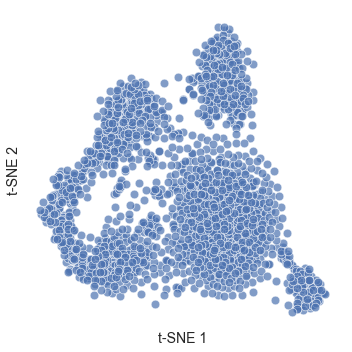

CPU times: user 23.7 s, sys: 1.09 s, total: 24.8 s
Wall time: 24.8 s


In [48]:
%time nvr_tSNE = fcc_utils.fcc_tSNE(nvr_data, p=50) # perplexity 50

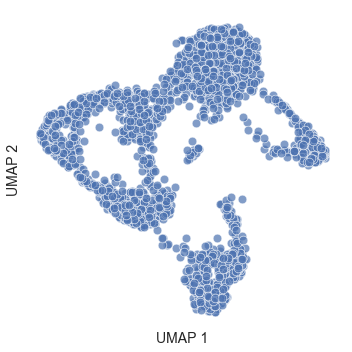

CPU times: user 7.77 s, sys: 488 ms, total: 8.26 s
Wall time: 8.3 s


In [49]:
%time nvr_UMAP = fcc_utils.fcc_UMAP(nvr_data)

Now compare the Euclidean distance conservation of different DR methods following NVR feature selection.

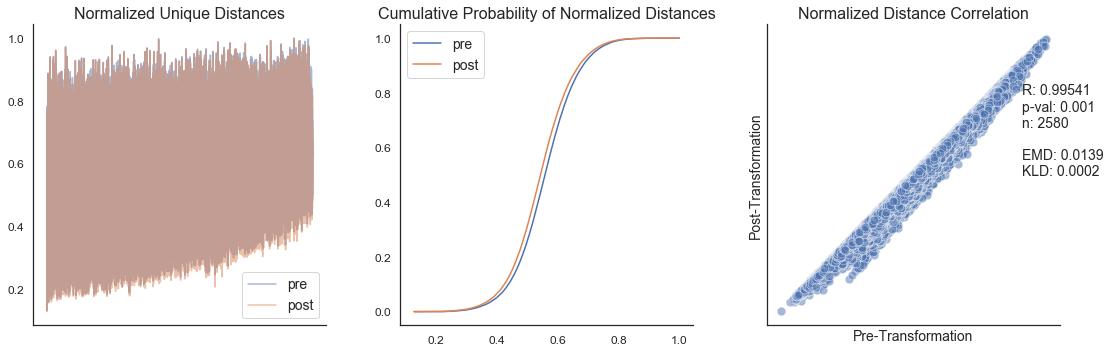

CPU times: user 3min 38s, sys: 22.8 s, total: 4min 1s
Wall time: 4min 4s


In [50]:
%time mantel, EMD, KLD = fcc_utils.compare_euclid(pre=nvr_data, post=nvr_PCA)

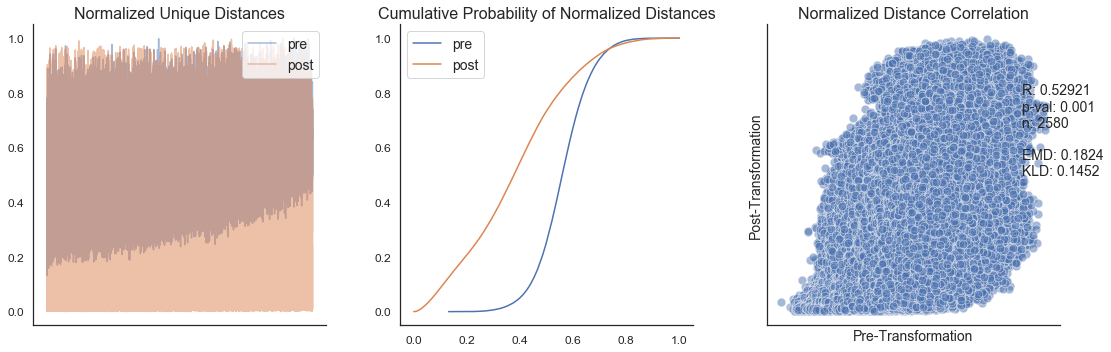

CPU times: user 3min 42s, sys: 22.7 s, total: 4min 5s
Wall time: 4min 5s


In [51]:
%time mantel, EMD, KLD = fcc_utils.compare_euclid(pre=nvr_data, post=nvr_tSNE)

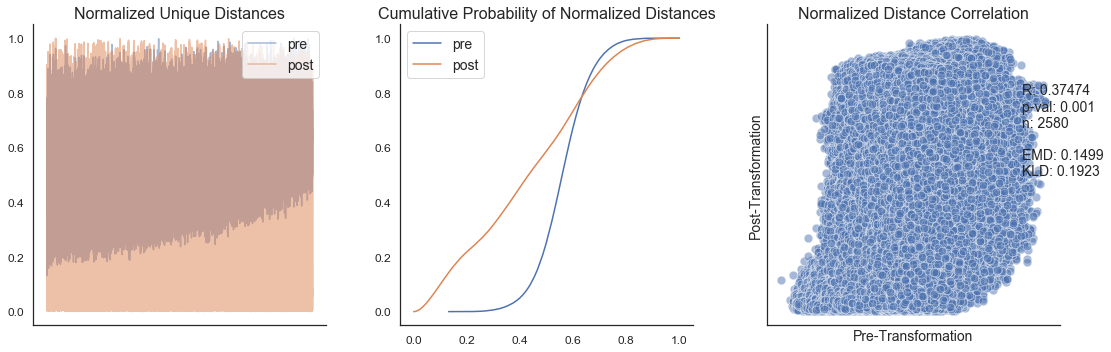

CPU times: user 3min 43s, sys: 22 s, total: 4min 5s
Wall time: 4min 5s


In [52]:
%time mantel, EMD, KLD = fcc_utils.compare_euclid(pre=nvr_data, post=nvr_UMAP)

use discrete dataset.  
NVR is designed for continuous datasets.  
May need to look at other feature selection algs.  